<center>
<h1> Natural Language Processing with Disaster texts </h1>
<h2>Data Mining and Big Data Analytics</h2>
<h3>Azizbek Ussenov</h3>
<h4>2024-2025</h4>
</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import gensim.downloader as api
import re
import html
import emoji
import contractions
import pandas as pd
import torch
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
from transformers import Trainer, TrainingArguments

import warnings
warnings.filterwarnings('ignore')

/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<hr>

#### Loading dataset

In [2]:
# Train Dataset
df_train = pd.read_csv('train.csv')

# Test Dataset
df_test = pd.read_csv('test.csv')

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

There is class imbalance non-disaster tweets being dominant. In general, transformer will be used as a final model. As transformers do not need much preprocessing, I will not deal with class imbalance. It is because when I tried to handle them the performance got decreased, so in my final model there will be less preprocessing.

In [6]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test_id = df_test[['id']].copy()

In [8]:
def drop_columns(df, columns:list):
    return df.drop(columns=columns, errors='ignore')

In [9]:
df_train = drop_columns(df_train, ['id','keyword', 'location'])
df_test = drop_columns(df_test, ['id','keyword', 'location'])

In [10]:
df_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


I remove everything that looks messy and lemmatize i.e. groups similar words, reducing the number of different words in a data set and simplifying text data. This preprocessing is solely for the models with One-hot encoding, Bag of Words, TF-IFD, and Word2vec. I will preprocess the tweets with less processing once again for transformer as I approach towards end.

In [11]:
nlp = spacy.load("en_core_web_sm")

def clean_preprocess(text):
    if pd.isnull(text):
        return ""

    text = text.strip()
    text = html.unescape(text)                              # Fix &amp;, &lt;, etc.

    text = text.replace("‰ÛÏ", '"').replace("‰Û", '"')     # double quotes
    text = text.replace("‰Û÷", "'").replace("‰Ûª", "'")     # single quotes
    text = text.replace("‰Û¢", "-").replace("‰Û_", "-")     # hyphen issues
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"#", "", text)                           # remove hashtags
    text = re.sub(r"\n", " ", text)                         # remove newline chars
    text = re.sub(r"http\S+", "", text)                     # remove URLs
    text = re.sub(r"@\w+", "", text)                        # remove mentions
    text = emoji.demojize(text, delimiters=(" ", " "))      # convert emoji to text

    text = re.sub(r"w/e", "whatever", text)                 # typos, slang and informal abbreviations below
    text = re.sub(r"w/", "with", text)
    text = re.sub(r"Ph0tos", "Photos", text)
    text = re.sub(r"amirite", "am I right", text)
    text = re.sub(r"exp0sed", "exposed", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"amageddon", "armageddon", text)
    text = re.sub(r"Trfc", "Traffic", text)
    text = re.sub(r"8/5/2015", "2015-08-05", text)
    text = re.sub(r"WindStorm", "Wind Storm", text)
    text = re.sub(r"8/6/2015", "2015-08-06", text)
    text = re.sub(r"10:38PM", "10:38 PM", text)
    text = re.sub(r"10:30pm", "10:30 PM", text)
    text = re.sub(r"16yr", "16 year", text)
    text = re.sub(r"lmao", "laughing my ass off", text)   


    text = re.sub(r"PantherAttack", "Panther Attack", text)  # hashtags and usernames below
    text = re.sub(r"NASAHurricane", "NASA Hurricane", text)
    text = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", text)
    text = re.sub(r"thankU", "thank you", text)
    text = re.sub(r"OffensiveContent", "Offensive Content", text)
    text = re.sub(r"WorstSummerJob", "Worst Summer Job", text)
    text = re.sub(r"aRmageddon", "armageddon", text)
    text = re.sub(r"Throwingknifes", "Throwing knives", text)
    text = re.sub(r"til_now", "until now", text)
    text = re.sub(r"volcanoinRussia", "volcano in Russia", text)
    text = re.sub(r"abstorm", "Alberta Storm", text)
    text = re.sub(r"IDFire", "Idaho Fire", text)
    text = re.sub(r"DETECTADO", "Detected", text)
    text = re.sub(r"RockyFire", "Rocky Fire", text)
    text = re.sub(r"yycstorm", "Calgary Storm", text)
    text = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", text)
    text = re.sub(r"NoSurrender", "No Surrender", text)
    text = re.sub(r"NotExplained", "Not Explained", text)
    text = re.sub(r"greatbritishbakeoff", "great british bake off", text)
    text = re.sub(r"BlackLivesMatter", "Black Lives Matter", text)
    text = re.sub(r"TornadoGiveaway", "Tornado Giveaway", text)
    text = re.sub(r"SouthDowns", "South Downs", text)
    text = re.sub(r"S3XLEAK", "sex leak", text)


    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)       # urls


    text = re.sub(r"MH370", "Malaysia Airlines Flight 370", text)   # acronyms below
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"okwx", "Oklahoma City Weather", text)
    text = re.sub(r"arwx", "Arkansas Weather", text)    
    text = re.sub(r"gawx", "Georgia Weather", text)  
    text = re.sub(r"scwx", "South Carolina Weather", text)  
    text = re.sub(r"cawx", "California Weather", text)
    text = re.sub(r"tnwx", "Tennessee Weather", text)
    text = re.sub(r"azwx", "Arizona Weather", text)  
    text = re.sub(r"alwx", "Alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)    
    text = re.sub(r"usNWSgov", "United States National Weather Service", text)
    text = re.sub(r"Suruc", "Sanliurfa", text)   
    
    text = contractions.fix(text)    # expand contractions
    
    text = text.lower()

    doc = nlp(text) # lemmatization
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    
    return lemmatized_text

In [12]:
df_train["text"] = df_train["text"].apply(clean_preprocess)
df_test["text"] = df_test["text"].apply(clean_preprocess)

In [13]:
df_train

,text,target
0,our deed be the reason of this earthquake may ...,1
1,forest fire near la ronge sask canada,1
2,all resident ask to shelter in place be be not...,1
3,"13,000 people receive wildfire evacuation orde...",1
4,just get send this photo from ruby alaska as s...,1
...,...,...
7608,two giant crane hold a bridge collapse into ne...,1
7609,the out of control wild fire in california eve...,1
7610,m1.94 01:04 utc]?5 km s of volcano hawaii,1
7611,police investigate after an e bike collide wit...,1


There are some duplicates with different target values. So, let's inspect them. Afterwards, I will drop them by keeping the first one as the first occurences best labels the text.

In [14]:
conflicting = df_train.groupby("text")["target"].nunique()
conflicting_texts = conflicting[conflicting > 1].index

conflicting_rows = df_train[df_train["text"].isin(conflicting_texts)]
conflicting_rows = conflicting_rows.sort_values("text").reset_index(drop=True)

In [15]:
conflicting_rows

,text,target
0,.potus strategicpatience be a strategy for gen...,1
1,.potus strategicpatience be a strategy for gen...,1
2,.potus strategicpatience be a strategy for gen...,1
3,.potus strategicpatience be a strategy for gen...,0
4,.potus strategicpatience be a strategy for gen...,1
...,...,...
282,you.s national park service tonto national for...,1
283,you.s national park service tonto national for...,1
284,you.s national park service tonto national for...,0
285,you.s national park service tonto national for...,0


In [16]:
for idx, row in conflicting_rows.iterrows():
    print(f"Row {idx}:")
    print(row['text'])
    print(row['target'])
    print("-" * 40)

Row 0:
.potus strategicpatience be a strategy for genocide refugee idp internally displace people horror etc
1
----------------------------------------
Row 1:
.potus strategicpatience be a strategy for genocide refugee idp internally displace people horror etc
1
----------------------------------------
Row 2:
.potus strategicpatience be a strategy for genocide refugee idp internally displace people horror etc
1
----------------------------------------
Row 3:
.potus strategicpatience be a strategy for genocide refugee idp internally displace people horror etc
0
----------------------------------------
Row 4:
.potus strategicpatience be a strategy for genocide refugee idp internally displace people horror etc
1
----------------------------------------
Row 5:
2pc 18w cree lead work light offroad lamp car truck boat mining 4wd flood beam full rea
0
----------------------------------------
Row 6:
2pc 18w cree lead work light offroad lamp car truck boat mining 4wd flood beam full rea
1
-----

In [17]:
print("before drop duplicates:", len(df_train))

df_train.drop_duplicates(subset=['text'], keep='first', inplace=True)

print("after drop duplicates:", len(df_train))

before drop duplicates: 7613
after drop duplicates: 6858


Let's visualize the distribution of text lengths in the training data

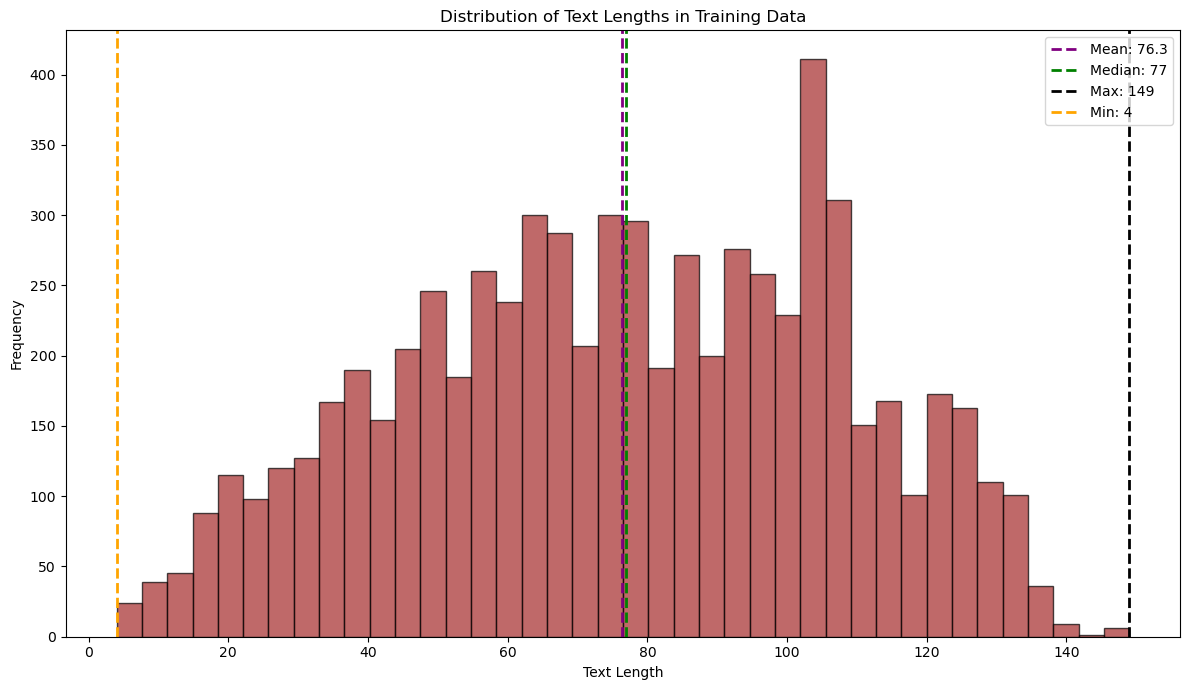

In [18]:
train_text_lengths = [len(row) for row in df_train.text]

mean_len = np.mean(train_text_lengths)
median_len = np.median(train_text_lengths)
max_len = max(train_text_lengths)
min_len = min(train_text_lengths)

plt.figure(figsize=(12, 7))
plt.hist(train_text_lengths, bins=40, color='brown', edgecolor='black', alpha=0.7)

plt.axvline(mean_len, color='purple', linestyle='dashed', linewidth=2, label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_len:.0f}')
plt.axvline(max_len, color='black', linestyle='dashed', linewidth=2, label=f'Max: {max_len}')
plt.axvline(min_len, color='orange', linestyle='dashed', linewidth=2, label=f'Min: {min_len}')

plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

<hr>

### One hot encoding

In [19]:
X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):
    
    binary = trial.suggest_categorical("binary", [False])
    ngram_range = trial.suggest_categorical("ngram_range", [(1, 1), (1, 2)])
    min_df = trial.suggest_int("min_df", 1, 5)
    max_features = trial.suggest_categorical("max_features", [None, 1000, 3000, 5000])

    
    C = trial.suggest_float("C", 0.01, 10.0, log=True) # model hyperparameter


    pipeline = Pipeline([
        ("vectorizer", CountVectorizer(
            binary=binary,
            ngram_range=ngram_range,
            min_df=min_df,
            max_features=max_features
        )),
        ("svm", LinearSVC(C=C, max_iter=10000))
    ])

    score = cross_val_score(pipeline, X_train, y_train, scoring="f1", cv=3, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(" Best Hyperparameters Found:")
for k, v in best_params.items():
    print(f"{k}: {v}")

# best param pipeline
best_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(
        binary=best_params["binary"],
        ngram_range=best_params["ngram_range"],
        min_df=best_params["min_df"],
        max_features=best_params["max_features"]
    )),
    ("svm", LinearSVC(C=best_params["C"], max_iter=10000))
])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_val)

print("\n Validation Results:")
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


[I 2025-04-06 22:01:09,833] A new study created in memory with name: no-name-4d6b3afb-1f42-4769-966a-23915acd2d23
[I 2025-04-06 22:01:12,536] Trial 0 finished with value: 0.6972533461413528 and parameters: {'binary': False, 'ngram_range': (1, 2), 'min_df': 1, 'max_features': 3000, 'C': 0.017008919244797294}. Best is trial 0 with value: 0.6972533461413528.
[I 2025-04-06 22:01:13,175] Trial 1 finished with value: 0.6732022501398199 and parameters: {'binary': False, 'ngram_range': (1, 1), 'min_df': 5, 'max_features': 5000, 'C': 2.2525749178918844}. Best is trial 0 with value: 0.6972533461413528.
[I 2025-04-06 22:01:13,309] Trial 2 finished with value: 0.6890452662893125 and parameters: {'binary': False, 'ngram_range': (1, 2), 'min_df': 3, 'max_features': None, 'C': 0.24982405867658836}. Best is trial 0 with value: 0.6972533461413528.
[I 2025-04-06 22:01:13,889] Trial 3 finished with value: 0.6992755082043441 and parameters: {'binary': False, 'ngram_range': (1, 1), 'min_df': 1, 'max_featur

 Best Hyperparameters Found:
binary: False
ngram_range: (1, 1)
min_df: 2
max_features: 1000
C: 0.046211215557067684

 Validation Results:
F1 Score: 0.7141403865717192

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       838
           1       0.78      0.66      0.71       534

    accuracy                           0.80      1372
   macro avg       0.79      0.77      0.78      1372
weighted avg       0.79      0.80      0.79      1372



In [20]:
test_preds = best_pipeline.predict(df_test['text'])

# Add predictions to test_df
df_test["target"] = test_preds

In [21]:
# submission_2 = pd.DataFrame()
# submission_2['id'] = test_id['id']
# submission_2['target'] = test_preds
# # submission_2.to_csv("submission_2.csv", index=False)

<hr>

### Bag of words

In [22]:
X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    
    binary = trial.suggest_categorical("binary", [False])
    max_features = trial.suggest_categorical("max_features", [1000, 3000, 5000, None])
    ngram_range = trial.suggest_categorical("ngram_range", [(1, 1), (1, 2)])
    min_df = trial.suggest_int("min_df", 1, 5)

    
    C = trial.suggest_float("C", 0.01, 10.0, log=True)

    vectorizer = CountVectorizer(
        binary=binary,
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df
    )

    model = LinearSVC(C=C, max_iter=10000)

    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("svm", model)
    ])

    score = cross_val_score(pipeline, X_train, y_train, scoring="f1", cv=3, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best Hyperparameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

best_vectorizer = CountVectorizer(
    binary=False,
    max_features=study.best_params["max_features"],
    ngram_range=study.best_params["ngram_range"],
    min_df=study.best_params["min_df"]
)

best_model = LinearSVC(C=study.best_params["C"], max_iter=10000)

X_train_final = best_vectorizer.fit_transform(X_train)
X_val_final = best_vectorizer.transform(X_val)
best_model.fit(X_train_final, y_train)

y_pred = best_model.predict(X_val_final)

print("\n Validation Set Evaluation:")
print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


[I 2025-04-06 22:01:18,391] A new study created in memory with name: no-name-6dc12eb5-1a29-479a-8949-d530f01ada4f
[I 2025-04-06 22:01:18,468] Trial 0 finished with value: 0.6749305815484883 and parameters: {'binary': False, 'max_features': None, 'ngram_range': (1, 1), 'min_df': 5, 'C': 1.8339294021410915}. Best is trial 0 with value: 0.6749305815484883.
[I 2025-04-06 22:01:18,520] Trial 1 finished with value: 0.6986989417144992 and parameters: {'binary': False, 'max_features': 3000, 'ngram_range': (1, 1), 'min_df': 3, 'C': 0.15026535170494246}. Best is trial 1 with value: 0.6986989417144992.
[I 2025-04-06 22:01:18,573] Trial 2 finished with value: 0.7056496628185557 and parameters: {'binary': False, 'max_features': 5000, 'ngram_range': (1, 1), 'min_df': 4, 'C': 0.034561621668044634}. Best is trial 2 with value: 0.7056496628185557.
[I 2025-04-06 22:01:18,685] Trial 3 finished with value: 0.6863166692893365 and parameters: {'binary': False, 'max_features': 5000, 'ngram_range': (1, 2), 'm

Best Hyperparameters:
binary: False
max_features: 3000
ngram_range: (1, 1)
min_df: 4
C: 0.054777392960492874

 Validation Set Evaluation:
F1 Score: 0.7088866189989785
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       838
           1       0.78      0.65      0.71       534

    accuracy                           0.79      1372
   macro avg       0.79      0.77      0.77      1372
weighted avg       0.79      0.79      0.79      1372



In [23]:
X_test = best_vectorizer.transform(df_test['text'])
test_preds = best_model.predict(X_test)

df_test["target"] = test_preds

In [24]:
# submission_3 = pd.DataFrame()
# submission_3['id'] = test_id['id']
# submission_3['target'] = test_preds
# submission_3.to_csv("submission_3.csv", index=False)

<hr>

### TF-IDF

In [25]:
X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):

    max_features = trial.suggest_categorical("max_features", [1000, 3000, 5000, None])
    ngram_range = trial.suggest_categorical("ngram_range", [(1, 1), (1, 2)])
    min_df = trial.suggest_int("min_df", 1, 5)

    C = trial.suggest_float("C", 0.01, 10.0, log=True)

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=min_df
        )),
        ("svm", CalibratedClassifierCV(LinearSVC(C=C, max_iter=10000), cv=3))
    ])

    score = cross_val_score(pipeline, X_train, y_train, scoring="f1", cv=3, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print(" Best Hyperparameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

best_vectorizer = TfidfVectorizer(
    max_features=study.best_params["max_features"],
    ngram_range=study.best_params["ngram_range"],
    min_df=study.best_params["min_df"]
)

final_svm = CalibratedClassifierCV(
    LinearSVC(C=study.best_params["C"], max_iter=10000), cv=3
)

X_train_vec = best_vectorizer.fit_transform(X_train)
X_val_vec = best_vectorizer.transform(X_val)

final_svm.fit(X_train_vec, y_train)
y_pred = final_svm.predict(X_val_vec)

print("\n Validation Set Evaluation:")
print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


[I 2025-04-06 22:01:21,913] A new study created in memory with name: no-name-4118fde3-bfa3-4b1e-8a5b-24a07ef1f986
[I 2025-04-06 22:01:22,038] Trial 0 finished with value: 0.7010822061128826 and parameters: {'max_features': 5000, 'ngram_range': (1, 1), 'min_df': 1, 'C': 3.113342203871947}. Best is trial 0 with value: 0.7010822061128826.
[I 2025-04-06 22:01:22,186] Trial 1 finished with value: 0.7074750785422292 and parameters: {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 2, 'C': 0.061928840289291895}. Best is trial 1 with value: 0.7074750785422292.
[I 2025-04-06 22:01:22,243] Trial 2 finished with value: 0.719939214081775 and parameters: {'max_features': None, 'ngram_range': (1, 1), 'min_df': 3, 'C': 0.17632089401186635}. Best is trial 2 with value: 0.719939214081775.
[I 2025-04-06 22:01:22,307] Trial 3 finished with value: 0.6795385887049447 and parameters: {'max_features': None, 'ngram_range': (1, 1), 'min_df': 4, 'C': 3.292522761941692}. Best is trial 2 with value: 0.71993

 Best Hyperparameters:
max_features: None
ngram_range: (1, 2)
min_df: 1
C: 2.178302505433244

 Validation Set Evaluation:
F1 Score: 0.748062015503876
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       838
           1       0.78      0.72      0.75       534

    accuracy                           0.81      1372
   macro avg       0.80      0.79      0.80      1372
weighted avg       0.81      0.81      0.81      1372



In [26]:
X_test = best_vectorizer.transform(df_test['text'])
test_preds = final_svm.predict(X_test)

df_test["target"] = test_preds

In [27]:
# submission_4 = pd.DataFrame()
# submission_4['id'] = test_id['id']
# submission_4['target'] = test_preds
# submission_4.to_csv("submission_4.csv", index=False)

<hr>

### Word2Vec

In [28]:
# loading of pre-trained Word2Vec
print("Loading Word2Vec model...")
w2v_model = api.load("word2vec-google-news-300")

# converting text to mean word embedding
def text_to_vector(text, model=w2v_model, dim=300):
    words = text.split()
    valid_words = [word for word in words if word in model]
    if not valid_words:
        return np.zeros(dim)
    return np.mean([model[word] for word in valid_words], axis=0)


X = np.vstack(df_train['text'].apply(text_to_vector))
y = df_train['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# MLP model
def create_mlp(n_layers, units, dropout_rate, activation, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for i in range(n_layers):
        model.add(layers.Dense(units[i], activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy')
    return model


def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    units = [
        trial.suggest_int(f"units_l{i+1}", 64, 256, step=64) if i < n_layers else 0
        for i in range(3)
    ]
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = create_mlp(n_layers, units, dropout_rate, activation, lr)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    val_probs = model.predict(X_val)
    val_preds = (val_probs >= 0.5).astype(int)
    return f1_score(y_val, val_preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)


best_params = study.best_params
units = [best_params.get("units_l1", 0), best_params.get("units_l2", 0), best_params.get("units_l3", 0)]
final_model = create_mlp(best_params['n_layers'], units, best_params['dropout_rate'],
                         best_params['activation'], best_params['learning_rate'])
final_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

val_preds = (final_model.predict(X_val) >= 0.5).astype(int)
print("\nValidation F1-score:", f1_score(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))


Loading Word2Vec model...


[I 2025-04-06 22:01:48,203] A new study created in memory with name: no-name-f3e995e7-32cc-4c2b-9214-e069e7cbd380
2025-04-06 22:01:49.913747: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43/43 [==============================] - 0s 305us/step


[I 2025-04-06 22:01:52,171] Trial 0 finished with value: 0.6996966632962589 and parameters: {'n_layers': 3, 'units_l1': 64, 'units_l2': 64, 'units_l3': 256, 'activation': 'relu', 'dropout_rate': 0.07560367550413033, 'learning_rate': 0.0020560233488107183}. Best is trial 0 with value: 0.6996966632962589.


43/43 [==============================] - 0s 265us/step


[I 2025-04-06 22:01:53,184] Trial 1 finished with value: 0.7400555041628122 and parameters: {'n_layers': 2, 'units_l1': 64, 'units_l2': 128, 'activation': 'tanh', 'dropout_rate': 0.4538016708524871, 'learning_rate': 0.00725530082003326}. Best is trial 1 with value: 0.7400555041628122.


43/43 [==============================] - 0s 462us/step


[I 2025-04-06 22:01:54,457] Trial 2 finished with value: 0.7027027027027027 and parameters: {'n_layers': 2, 'units_l1': 128, 'units_l2': 192, 'activation': 'tanh', 'dropout_rate': 0.386467395812036, 'learning_rate': 0.009799367552194675}. Best is trial 1 with value: 0.7400555041628122.


43/43 [==============================] - 0s 246us/step


[I 2025-04-06 22:01:55,289] Trial 3 finished with value: 0.7467411545623837 and parameters: {'n_layers': 1, 'units_l1': 64, 'activation': 'tanh', 'dropout_rate': 0.40925672394460094, 'learning_rate': 0.0015406183671432944}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 302us/step


[I 2025-04-06 22:01:56,690] Trial 4 finished with value: 0.7418502202643171 and parameters: {'n_layers': 1, 'units_l1': 256, 'activation': 'relu', 'dropout_rate': 0.4776559555562577, 'learning_rate': 0.003100995652822562}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 324us/step


[I 2025-04-06 22:01:58,302] Trial 5 finished with value: 0.7381174277726001 and parameters: {'n_layers': 3, 'units_l1': 256, 'units_l2': 64, 'units_l3': 256, 'activation': 'relu', 'dropout_rate': 0.3224692580040279, 'learning_rate': 0.00955167072840929}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 253us/step


[I 2025-04-06 22:01:59,222] Trial 6 finished with value: 0.7227227227227228 and parameters: {'n_layers': 2, 'units_l1': 64, 'units_l2': 64, 'activation': 'relu', 'dropout_rate': 0.3291977585354237, 'learning_rate': 0.0006274520460955949}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 271us/step


[I 2025-04-06 22:02:00,255] Trial 7 finished with value: 0.7417840375586855 and parameters: {'n_layers': 2, 'units_l1': 64, 'units_l2': 192, 'activation': 'tanh', 'dropout_rate': 0.35132347070160724, 'learning_rate': 0.0070732376180516485}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 349us/step


[I 2025-04-06 22:02:01,791] Trial 8 finished with value: 0.6989748369058714 and parameters: {'n_layers': 3, 'units_l1': 192, 'units_l2': 128, 'units_l3': 192, 'activation': 'tanh', 'dropout_rate': 0.24137286288829096, 'learning_rate': 0.005869476894488713}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 271us/step


[I 2025-04-06 22:02:02,750] Trial 9 finished with value: 0.7456059204440333 and parameters: {'n_layers': 1, 'units_l1': 192, 'activation': 'relu', 'dropout_rate': 0.4641183416315371, 'learning_rate': 0.000460904500349788}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 255us/step


[I 2025-04-06 22:02:03,603] Trial 10 finished with value: 0.7178988326848249 and parameters: {'n_layers': 1, 'units_l1': 128, 'activation': 'tanh', 'dropout_rate': 0.18317916879673304, 'learning_rate': 0.0001103948605289804}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 276us/step


[I 2025-04-06 22:02:04,574] Trial 11 finished with value: 0.7375609756097561 and parameters: {'n_layers': 1, 'units_l1': 192, 'activation': 'relu', 'dropout_rate': 0.49434458102666345, 'learning_rate': 0.0005008206165579386}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 264us/step


[I 2025-04-06 22:02:05,524] Trial 12 finished with value: 0.7360308285163777 and parameters: {'n_layers': 1, 'units_l1': 192, 'activation': 'tanh', 'dropout_rate': 0.4078564216643136, 'learning_rate': 0.0002604701838775023}. Best is trial 3 with value: 0.7467411545623837.


43/43 [==============================] - 0s 252us/step


[I 2025-04-06 22:02:06,383] Trial 13 finished with value: 0.7497656982193065 and parameters: {'n_layers': 1, 'units_l1': 128, 'activation': 'relu', 'dropout_rate': 0.24462161618328218, 'learning_rate': 0.0014692303107625708}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 247us/step


[I 2025-04-06 22:02:07,232] Trial 14 finished with value: 0.7473583093179635 and parameters: {'n_layers': 1, 'units_l1': 128, 'activation': 'relu', 'dropout_rate': 0.15432598808110748, 'learning_rate': 0.0015702060644501856}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 245us/step


[I 2025-04-06 22:02:08,151] Trial 15 finished with value: 0.7440212577502214 and parameters: {'n_layers': 1, 'units_l1': 128, 'activation': 'relu', 'dropout_rate': 0.10757084889922941, 'learning_rate': 0.0011200954875793775}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 339us/step


[I 2025-04-06 22:02:09,478] Trial 16 finished with value: 0.7207920792079208 and parameters: {'n_layers': 2, 'units_l1': 128, 'units_l2': 256, 'activation': 'relu', 'dropout_rate': 0.16251147464368784, 'learning_rate': 0.002116986338919491}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 262us/step


[I 2025-04-06 22:02:10,338] Trial 17 finished with value: 0.7465034965034965 and parameters: {'n_layers': 1, 'units_l1': 128, 'activation': 'relu', 'dropout_rate': 0.020607512497950203, 'learning_rate': 0.003442408119983431}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 265us/step


[I 2025-04-06 22:02:11,211] Trial 18 finished with value: 0.7475113122171946 and parameters: {'n_layers': 1, 'units_l1': 128, 'activation': 'relu', 'dropout_rate': 0.25218061693386773, 'learning_rate': 0.0008564074383786415}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 346us/step


[I 2025-04-06 22:02:12,630] Trial 19 finished with value: 0.7226061204343535 and parameters: {'n_layers': 2, 'units_l1': 192, 'units_l2': 256, 'activation': 'relu', 'dropout_rate': 0.24961455228416668, 'learning_rate': 0.0008034896507103408}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 283us/step


[I 2025-04-06 22:02:13,859] Trial 20 finished with value: 0.7495361781076066 and parameters: {'n_layers': 2, 'units_l1': 128, 'units_l2': 192, 'activation': 'relu', 'dropout_rate': 0.2892064220601783, 'learning_rate': 0.00033700886783144096}. Best is trial 13 with value: 0.7497656982193065.


43/43 [==============================] - 0s 299us/step


[I 2025-04-06 22:02:15,057] Trial 21 finished with value: 0.7511916110581506 and parameters: {'n_layers': 2, 'units_l1': 128, 'units_l2': 192, 'activation': 'relu', 'dropout_rate': 0.2842220518133107, 'learning_rate': 0.0002859678214638433}. Best is trial 21 with value: 0.7511916110581506.


43/43 [==============================] - 0s 273us/step


[I 2025-04-06 22:02:16,302] Trial 22 finished with value: 0.7531956735496559 and parameters: {'n_layers': 2, 'units_l1': 128, 'units_l2': 192, 'activation': 'relu', 'dropout_rate': 0.2811146747068687, 'learning_rate': 0.00024152506562239183}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 314us/step


[I 2025-04-06 22:02:19,134] Trial 23 finished with value: 0.7502392344497608 and parameters: {'n_layers': 3, 'units_l1': 128, 'units_l2': 192, 'units_l3': 64, 'activation': 'relu', 'dropout_rate': 0.20679371019226775, 'learning_rate': 0.0001538114665314072}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 346us/step


[I 2025-04-06 22:02:20,671] Trial 24 finished with value: 0.7208121827411168 and parameters: {'n_layers': 3, 'units_l1': 192, 'units_l2': 192, 'units_l3': 64, 'activation': 'relu', 'dropout_rate': 0.19878922311317826, 'learning_rate': 0.00014794048385653104}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 315us/step


[I 2025-04-06 22:02:22,051] Trial 25 finished with value: 0.7450980392156863 and parameters: {'n_layers': 3, 'units_l1': 128, 'units_l2': 192, 'units_l3': 64, 'activation': 'relu', 'dropout_rate': 0.2892727464473788, 'learning_rate': 0.00022135292572712434}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 279us/step


[I 2025-04-06 22:02:23,111] Trial 26 finished with value: 0.7420289855072464 and parameters: {'n_layers': 2, 'units_l1': 64, 'units_l2': 256, 'activation': 'relu', 'dropout_rate': 0.20815455705625888, 'learning_rate': 0.0001750832076916925}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 258us/step


[I 2025-04-06 22:02:24,190] Trial 27 finished with value: 0.7410281280310378 and parameters: {'n_layers': 2, 'units_l1': 128, 'units_l2': 128, 'activation': 'relu', 'dropout_rate': 0.13306711141340102, 'learning_rate': 0.00010399617382242814}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 351us/step


[I 2025-04-06 22:02:25,955] Trial 28 finished with value: 0.7417923691215617 and parameters: {'n_layers': 3, 'units_l1': 192, 'units_l2': 192, 'units_l3': 128, 'activation': 'relu', 'dropout_rate': 0.2871486526602715, 'learning_rate': 0.0003518290785011598}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 277us/step


[I 2025-04-06 22:02:27,122] Trial 29 finished with value: 0.7478591817316841 and parameters: {'n_layers': 3, 'units_l1': 64, 'units_l2': 128, 'units_l3': 128, 'activation': 'relu', 'dropout_rate': 0.06512609212243581, 'learning_rate': 0.00015566019812657855}. Best is trial 22 with value: 0.7531956735496559.


43/43 [==============================] - 0s 302us/step

Validation F1-score: 0.7396449704142012
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       811
           1       0.83      0.67      0.74       561

    accuracy                           0.81      1372
   macro avg       0.81      0.79      0.79      1372
weighted avg       0.81      0.81      0.80      1372



In [29]:
X_test = np.vstack(df_test['text'].apply(text_to_vector))
test_preds = (final_model.predict(X_test) >= 0.5).astype(int).ravel()
df_test["target"] = test_preds

102/102 [==============================] - 0s 276us/step


In [30]:
# submission_5 = pd.DataFrame()
# submission_5['id'] = test_id['id']
# submission_5['target'] = test_preds
# submission_5.to_csv("submission_5.csv", index=False)

<hr>

### Transformers

Preprocessing again for transformer use only

In [31]:
def clean_text_transformer(text):
    
        text = text.strip()                                             # leading/trailing spaces
        text = html.unescape(text)                                      # HTML entities
        text = text.replace("‰ÛÏ", '"').replace("‰Û", '"')            # double quotes
        text = text.replace("‰Û÷", "'").replace("‰Ûª", "'")             # single quotes
        text = text.replace("‰Û¢", "-").replace("‰Û_", "-")             # hyphen 
        text = re.sub(r"[^\x00-\x7F]+", "", text)                       # non-ASCII characters
        text = re.sub(r'http\S+', '', text)                             # URLs
        text = re.sub(r'@\w+', '', text)                                # mentions (@username)
        text = emoji.demojize(text, delimiters=(" ", " "))              # emojis
        text = contractions.fix(text)                                   # contractions
        text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)       # urls
        text = text.lower()
        
        return text

In [32]:
# Train Dataset
train_df = pd.read_csv('train.csv')

# Test Dataset
test_df = pd.read_csv('test.csv')

In [33]:
train_df["text"] = train_df["text"].apply(clean_text_transformer)
test_df["text"] = test_df["text"].apply(clean_text_transformer)

In [34]:
print("before drop duplicates", len(train_df))

train_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print("after drop duplicates", len(train_df))

before drop duplicates 7613
after drop duplicates 6949


Upgrade transformer just to be on the safe side

In [35]:
# !pip install --upgrade transformers

In [36]:
model_choice = "vinai/bertweet-base"

model = AutoModelForSequenceClassification.from_pretrained(model_choice, num_labels=2).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_choice)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [ ]:
tokenized_transformer_lengths = [len(tokenizer.encode(text)) for text in train_df.text]

print("Mean length:", np.mean(tokenized_transformer_lengths))
print("Median length:", np.median(tokenized_transformer_lengths))
print("Max length:", max(tokenized_transformer_lengths))
print("Min length:", min(tokenized_transformer_lengths))

Mean length: 21.11427820832786
Median length: 21.0
Max length: 86
Min length: 3


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.rename_column("target", "labels")

# Split train dataset into 80% train and 20% validation
train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)

# Extract train and validation datasets
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

# Define tokenization function
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128, return_tensors="pt")

# Apply tokenization
tokenized_train = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

In [ ]:
def metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    score = f1_score(labels, predictions, average="weighted")

    return {"f1": score, "accuracy": accuracy}

In [ ]:
training_args = TrainingArguments(

    output_dir="./results",
    logging_dir="./logs",
    report_to="none",
    logging_strategy="steps",
    logging_steps=20,

    eval_strategy="steps",
    eval_steps=20,
    save_steps=20,
    save_strategy="steps",
    save_total_limit=2,
    metric_for_best_model="f1",
    load_best_model_at_end=True,

    num_train_epochs=5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    weight_decay=0.05,    
    fp16=True  
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics = metrics,
)

trainer.train()

In [ ]:
predictions = trainer.predict(test_dataset=tokenized_test)

predicted_labels = np.argmax(predictions.predictions, axis=1)

In [ ]:
# submission_8 = pd.DataFrame()
# submission_8['id'] = test_id['id']
# submission_8['target'] = predicted_labels
# submission_8.to_csv("submission_transformer_final.csv", index=False)

In [ ]:
# from google.colab import files
# files.download('submission_transformer_final.csv')